# How to use Supervisely Python SDK for automatic image labeling with visual foundation models

## Introduction

Foundation models are large neural networks, which were trained on massive datasets. They are built to be universal and generalize will on data across wide range of domains. In computer vision, foundation models are often used for data pre-labeling - the process of generating image annotations which are then reviewed by human annotators to check their accuracy, adjusted (if necessary) and used as starting point for training machine learning models. So the pipeline is the following: generate initial data annotations with some (relatively) large neural network (like Kosmos 2, for example) and use this annotations to train lighter, faster neural network (like YOLO, for example) which can be then used in production without requiring significant computational resources.

In this tutorial, we will show you how to use Supervisely Python SDK to deploy and use modern visual foundation models.

If you are viewing this tutorial from GitHub, it is better to use [nbviewer](https://nbviewer.org/github/supervisely-ecosystem/auto-labeling-tutorial/blob/master/src/auto_labeling_tutorial.ipynb) since GitHub does not render videos.

## Input data overview

We will take a small dataset with images of hummingbirds and try to label it with visual foundation models:

![dataset](../tutorial_data/dataset.png)


## Environment preparation and libraries import

For running the code provided in this tutorial, you will have to install Supervisely Python SDK on your machine.

The latest stable version is available on PyPI, so you can easily do it with pip:

```bash
pip3 install supervisely
```

You can also refer to [official installation tutorial](https://github.com/supervisely/developer-portal/edit/main/getting-started/installation.md), which covers more use cases.

It will be also necessary to prepare two .env files: `supervisely.env` with [Supervisely account credentials](https://developer.supervisely.com/getting-started/basics-of-authentication) and `local.env` with Supervisely workspace ID and agent ID.

Here is how to get your workspace ID:

![workspace id 0](../tutorial_data/workspace_id_0.png)

![workspace id 1](../tutorial_data/workspace_id_1.png)

Here is how to get your agent ID:

![agent id 0](../tutorial_data/agent_id_0.png)

![agent id 1](../tutorial_data/agent_id_1.png)

![agent id 2](../tutorial_data/agent_id_2.png)

Your `local.env` file should look the following way:

```code
WORKSPACE_ID = your_workspace_id
AGENT_ID = your_agent_id
```

After SDK is installed, import necessary libraries, load Supervisely account credentials and set image display parameters:

In [24]:
import supervisely as sly
from dotenv import load_dotenv
from PIL import Image
import matplotlib.pyplot as plt


# load credentials
load_dotenv("../supervisely.env")
load_dotenv("../local.env")
api = sly.Api()

# set image display parameters
%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)

## Deploy visual foundation model

You can use the following foundation models with the help of Supervisely Python SDK:

- [Grounding DINO](https://github.com/IDEA-Research/GroundingDINO)
- [Florence 2](https://huggingface.co/microsoft/Florence-2-base)
- [Kosmos 2](https://github.com/microsoft/unilm/tree/master/kosmos-2)
- [Molmo](https://github.com/allenai/molmo)
- [Segment Anything 2](https://github.com/facebookresearch/segment-anything-2)

Grounding DINO, Kosmos 2 and Florence 2 are prompt-based object detection models (they generate bounding box annotations based on text prompt), Molmo - object pointing model (generates object points based on text prompt), Segment Anything 2 - interactive instance segmentation model (generates segmentation masks based on bounding box or point prompts). Kosmos 2, Florence 2 and Molmo can perform a wide range of different tasks (image captionaing, referring expression generation, etc.), but we will focus on their ability to generate image annotations based on text prompts.

You can get list of currently supported models the following way:


In [4]:
supported_models = sly.nn.auto_labeling.get_supported_models()
print(supported_models)

['Grounding DINO', 'Florence 2', 'Kosmos 2', 'Molmo', 'SAM 2']


Now let's select some specific model and get list of supported checkpoints for this model:

In [5]:
model_name = "Grounding DINO"
supported_checkpoints = sly.nn.auto_labeling.get_supported_checkpoints(model_name)
print(supported_checkpoints)

['grounding-dino-tiny', 'grounding-dino-base']


After defining model and checkpoint names, we can deploy selected foundation model:

In [ ]:
det_session = sly.nn.auto_labeling.deploy_foundation_model(
    model_name="Grounding DINO", checkpoint_name="grounding-dino-base", api=api
)

Let's get model's default inference settings (we will later modify them in order to label our data):

In [7]:
det_inference_settings = det_session.get_default_inference_settings()
print(det_inference_settings)

{'text_prompt': 'all objects.', 'box_threshold': 0.3, 'text_threshold': 0.3}


## Update model inference settings

Since we are dealing with a dataset of images with hummingbirds, it is necessary to change model inference settings in order to detect hummingbirds on images. We will change only text prompt and leave box and text thresholds as default:

In [8]:
det_inference_settings["text_prompt"] = "a hummingbird."

We will also add batch size parameter to model inference settings:

In [14]:
det_inference_settings["batch_size"] = 2
print(det_inference_settings)

{'text_prompt': 'a hummingbird.', 'box_threshold': 0.3, 'text_threshold': 0.3, 'batch_size': 2}


You can preview model predictions with given inference settings on specific image or random image from given dataset the following way:

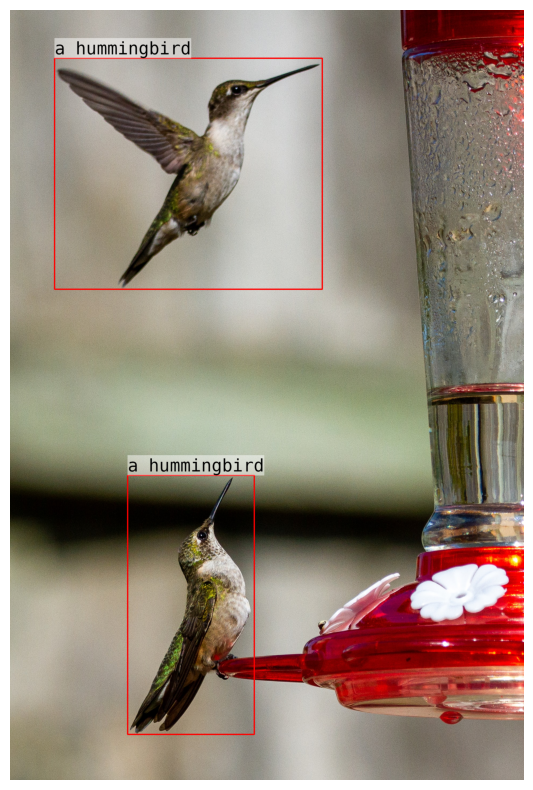

In [15]:
preview_image = sly.nn.auto_labeling.preview(
    nn_session=det_session,
    api=api,
    inference_settings=det_inference_settings,
    image_id=371068,
)
plt.axis("off")
plt.imshow(Image.fromarray(preview_image));

## Apply visual foundation model to images project

Now, when foundation model is deployed and inference settings were adjusted based on our needs, we can apply our deployed model to selected images project. Image annotations will be automatically uploaded to Supervisely platform. The function will also return image annotations as a list so we can use them to create additional image labels:

In [11]:
# define input project and dataset ids
project_id = 1182
dataset_ids = [2875]

# get detection annotations
det_anns = sly.nn.auto_labeling.object_detection(
    project_id,
    dataset_ids,
    det_session,
    api,
    det_inference_settings,
)

Labeling image batches with bounding boxes...: 100%|██████████| 2/2 [00:07<00:00,  3.88s/it]
{"message": "Successfully finished prelabeling process for object detection task", "timestamp": "2025-02-12T12:08:48.160Z", "level": "info"}


Result:

<video controls src="../tutorial_data/auto_labeling_result_det.mp4" />

## Use annotations produced by object detection model as an input for instance segmentation model

If we want our data to be labeled not only with bounding boxes, but also with segmentation masks, we can deploy instance segmentation model (Segment Anything 2) in a similar way and use bounding box annotations produced by Grounding DINO in order to label our images with segmentation masks.


In [22]:
# define segmentation model configuration
seg_model_name = "SAM 2"
seg_checkpoint_name = "sam2.1_hiera_small.pt"

# set inference mode to bbox and pass detection model predictions to inference settings
seg_inference_settings = {"bbox_predictions": det_anns, "mode": "bbox"}

# deploy segmentation model
seg_session = deploy_foundation_model(seg_model_name, seg_checkpoint_name, api)

# apply segmentation model to images project
seg_anns = sly.nn.auto_labeling.instance_segmentation(
    project_id,
    dataset_ids,
    seg_session,
    api,
    seg_inference_settings,
)

Labeling images with masks...: 100%|██████████| 4/4 [00:15<00:00,  3.85s/it]
{"message": "Successfully finished prelabeling process for instance segmentation task", "timestamp": "2025-02-12T13:02:44.761Z", "level": "info"}


Result:

<video controls src="../tutorial_data/auto_labeling_result_seg.mp4" />

## Alternative scenario: use object pointing model in combination with instance segmentation model

If you want to use points instead of bounding boxes as prompts for Segment Anything 2 or object detection foundation models are unable to detect your desired objects, you can try using Molmo - a powerful object pointing model - to label your images with points and then use these points as input prompt for SAM 2 in order to get segmentation masks:

In [ ]:
# define object pointing model configuration
point_model_name = "Molmo"
point_checkpoint_name = "Molmo-7B-O-0924"
point_inference_settings = {
    "text_prompt": "Count the hummingbirds",
}

# deploy object pointing model
point_session = sly.nn.auto_labeling.deploy_foundation_model(
    point_model_name, point_checkpoint_name, api
)

# apply object pointing model to images project
point_anns = sly.nn.auto_labeling.object_pointing(
    project_id,
    dataset_ids,
    point_session,
    api,
    point_inference_settings,
)

# define segmentation model configuration
seg_model_name = "SAM 2"
seg_checkpoint_name = "sam2.1_hiera_tiny.pt"
seg_inference_settings = {"point_predictions": point_anns, "mode": "points"}

# deploy segmentation model
seg_session = sly.nn.auto_labeling.deploy_foundation_model(seg_model_name, seg_checkpoint_name, api)

# apply segmentation model to images project
seg_anns = sly.nn.auto_labeling.instance_segmentation(
    project_id,
    dataset_ids,
    seg_session,
    api,
    seg_inference_settings,
)


If your input project is already labeled with bounding boxes or points, you can use SAM 2 model without having to pass bounding box / point annotations from some object detection / object pointing model. In that case you can just set "mode" to "bbox" or "points" without passing "bbox_predictions" or "point_predictions" to inference settings and existing project annotations will be used as input prompts for SAM 2.

## Acknowledgement

This tutorial is based on the following great works: [Grounding DINO](https://github.com/IDEA-Research/GroundingDINO), [Florence 2](https://huggingface.co/microsoft/Florence-2-base), [Kosmos 2](https://github.com/microsoft/unilm/tree/master/kosmos-2), [Molmo](https://github.com/allenai/molmo), [Segment Anything 2](https://github.com/facebookresearch/segment-anything-2).